## 均匀发出射线，提取碰撞点

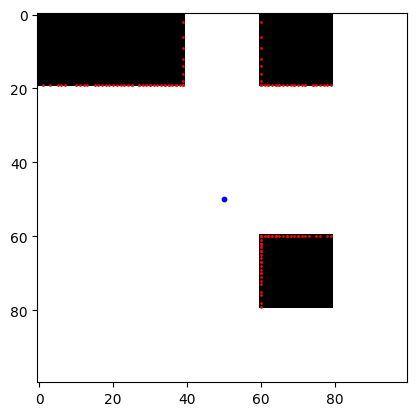

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(image, num_rays=360):
    height, width = image.shape
    center = (height // 2, width // 2)
    angles = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)
    
    edges = []

    for angle in angles:
        x, y = center
        dx, dy = np.cos(angle), np.sin(angle)
        
        while 0 <= x < width and 0 <= y < height:
            if image[int(y), int(x)] == 0:
                edges.append((int(x), int(y)))
                break
            x += dx
            y += dy

    return edges

# 示例栅格图
image = np.ones((100, 100))
image[0:20, 0:40] = 0
image[0:20, 60:80] = 0
image[60:80, 60:80] = 0

edges = detect_edges(image)
edge_x, edge_y = zip(*edges)

plt.imshow(image, cmap='gray')
plt.scatter(50, 50, color='blue', s=10)
plt.scatter(edge_x, edge_y, color='red', s=1)
plt.show()

## 先提取边界点，再连线检测有无遮挡

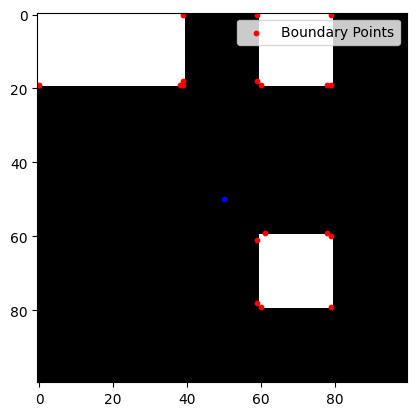

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def extract_contour_points(image):
    # Detect edges
    edges = cv2.Canny(image, 100, 200)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def ray_casting_boundaries(contours, center, num_bins=360):
    bins = [[] for _ in range(num_bins)]
    angle_step = 2 * np.pi / num_bins
    
    for contour in contours:
        for point in contour:
            point = point[0]  # extract (x, y)
            dx, dy = point[0] - center[0], point[1] - center[1]
            angle = np.arctan2(dy, dx) % (2 * np.pi)
            distance = np.sqrt(dx**2 + dy**2)
            bin_index = int(angle // angle_step)
            
            if not bins[bin_index] or bins[bin_index][1] > distance:
                bins[bin_index] = (point, distance)
    
    boundary_points = [b[0] for b in bins if b]
    return boundary_points

image = np.zeros((100, 100), dtype=np.uint8)
# cv2.rectangle(image, (30, 30), (70, 70), 255, -1)  # Add a square obstacle
image[0:20, 0:40] = 255
image[0:20, 60:80] = 255
image[60:80, 60:80] = 255

center = (50, 50)  # Vehicle center
contours = extract_contour_points(image)
boundary_points = ray_casting_boundaries(contours, center)
# sparse_boundary_points = sparsify_points(boundary_points)

# Plotting
plt.imshow(image, cmap='gray')
plt.scatter(50, 50, color='blue', s=10)
plt.scatter(*zip(*boundary_points), color='red', s=10, label='Boundary Points')
plt.legend()
plt.show()

## 实车数据

In [3]:
# import json


# # data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/log_map_archive_711332cba321dc8ff1e5e90bc436bb66f92ea38eef50997a3f712fbea1a99c76.json'
# # data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/log_map_archive_b551f683a87f3c02a0ee8956257adb920ad01e05d674cbadb80145a80175ba4d.json'
# # data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/log_map_archive_d9a95c4e3c8f1873e1a755f945785d723c734ff71e92eb3a4e12997375473904.json'
# data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/log_map_archive_cc943a5f4ae488c6b180ba53311cd6e9c1b8c33da1c1b18603085f587fb5e8f6.json'
# with open(data_path, 'r') as file:
#     data = json.load(file)

# occ_data = data['occ_data']
# # occ_data = data['/perception/nv_cameras/occ_info']['occ_info'][0]['data']
# # occ_data

In [4]:
import json

data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/train_dataset_v2.0/train_dataset/d4d11ea31b823ad42e4da3ca2e0fdbf747d67086f92ec5671c3d7adaa0c2bf22/log_map_archive_d4d11ea31b823ad42e4da3ca2e0fdbf747d67086f92ec5671c3d7adaa0c2bf22.json'
# data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/new_subfolder_17/log_map_archive_42daa0d82241ac5f7026add5090a93fcb3d5872b368758d882d5bf154635c788.json'
# data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/new_subfolder_17/log_map_archive_77d150cef3273f822d894f730c8f9346a14960a78b1b9cd7ecdbb605d60c6539.json'
# data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/new_subfolder_17/log_map_archive_c44298c67d3b3889b8594b0c7308a7bc3cb2b2674229db2d843b6fb5a468aee1.json'
# data_path = '/home/SENSETIME/chengren1/ws/occ_to_vector/new_subfolder_17/log_map_archive_ddae404d857354dbc868ef9bf381a5600f0b07e3786934e06573884f773e5304.json'
with open(data_path, 'r') as file:
    data = json.load(file)

# occ_data = data['occ_data'][60]['data']
occ_data = data['occ_data']

In [5]:
xPartition_info = occ_data['xPartition_info']

length = 0
for i in xPartition_info['numVoxelsPerRange']:
    length += i
length

144

In [6]:
yPartition_info = occ_data['yPartition_info']
# yPartition_info

width = 0
for i in yPartition_info['numVoxelsPerRange']:
    width += i
width

120

In [7]:
# occ_data['occ_info']

In [19]:
image = np.zeros((length, width))

count = 0
for v in occ_data['occ_info']:
    x = v['index'][0]
    y = v['index'][1]
    # print(x, y, v['type'])
    if v['type'] == 2:
        image[x, y] = 2
        count+=1
        # print(x, y)
    elif v['type'] == 1:
        image[x, y] = 1

ego_x = 0
ego_y = width // 2


print(count)
for i in range(length):
    for j in range(width):
        print(i, j, image[i, j])

4299
0 0 0.0
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
0 5 0.0
0 6 0.0
0 7 0.0
0 8 0.0
0 9 0.0
0 10 0.0
0 11 0.0
0 12 0.0
0 13 2.0
0 14 2.0
0 15 2.0
0 16 2.0
0 17 2.0
0 18 2.0
0 19 2.0
0 20 2.0
0 21 2.0
0 22 2.0
0 23 2.0
0 24 2.0
0 25 2.0
0 26 2.0
0 27 2.0
0 28 2.0
0 29 2.0
0 30 2.0
0 31 2.0
0 32 2.0
0 33 2.0
0 34 2.0
0 35 2.0
0 36 2.0
0 37 1.0
0 38 1.0
0 39 1.0
0 40 1.0
0 41 1.0
0 42 1.0
0 43 1.0
0 44 1.0
0 45 1.0
0 46 1.0
0 47 1.0
0 48 1.0
0 49 1.0
0 50 1.0
0 51 1.0
0 52 1.0
0 53 1.0
0 54 1.0
0 55 1.0
0 56 1.0
0 57 1.0
0 58 1.0
0 59 1.0
0 60 1.0
0 61 1.0
0 62 1.0
0 63 1.0
0 64 2.0
0 65 2.0
0 66 2.0
0 67 0.0
0 68 1.0
0 69 1.0
0 70 1.0
0 71 1.0
0 72 1.0
0 73 1.0
0 74 1.0
0 75 1.0
0 76 1.0
0 77 1.0
0 78 1.0
0 79 1.0
0 80 1.0
0 81 1.0
0 82 1.0
0 83 1.0
0 84 1.0
0 85 1.0
0 86 1.0
0 87 1.0
0 88 1.0
0 89 1.0
0 90 1.0
0 91 1.0
0 92 1.0
0 93 2.0
0 94 2.0
0 95 0.0
0 96 0.0
0 97 0.0
0 98 0.0
0 99 2.0
0 100 2.0
0 101 2.0
0 102 2.0
0 103 2.0
0 104 2.0
0 105 0.0
0 106 0.0
0 107 0.0
0 108 0.0
0 109 0.0
0 110

In [9]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

p = figure(width=400, height=600, x_range=(width, 0), y_range=(0, length))

x_1 = []
y_1 = []
x_2 = []
y_2 = []
for i in range(length):
    for j in range(width):
        # print(i, j, image[i][j])
        if image[i][j] == 1:
            x_1.append(i)
            y_1.append(j)
        elif image[i][j] == 2:
            x_2.append(i)
            y_2.append(j)

p.scatter(y_1, x_1, color='green', size=1, alpha=0.1)
p.scatter(y_2, x_2, color='red', size=3, alpha=0.3)
p.scatter(ego_y, ego_x, color='blue', size=10)

# 在notebook中显示图像
output_notebook()
show(p)

Loading BokehJS ...

## 实车检测边界

In [10]:
def detect_edges(image, center, num_rays=180):
    length, width = image.shape
    (center_x, center_y) = center
    angles = np.linspace(-np.pi / 2, np.pi / 2, num_rays, endpoint=False)
    # angles_l = np.linspace(0, np.pi / 2, int(num_rays / 2), endpoint=False)
    # angles_r = np.linspace(-np.pi / 2, 0, int(num_rays / 2), endpoint=False)
    # angles = [*angles_l, *angles_r]

    edges = []

    for angle in angles:
        x, y = center_x, center_y
        dx, dy = np.cos(angle), np.sin(angle)
        
        while 0 <= x < length and 0 <= y < width:
            # print(angle, x, y, image[int(x), int(y)])
            # if image[int(x), int(y)] == 2 or int(x) == length-1 or int(y) == 0 or int(y) == width-1:
            if image[int(x), int(y)] == 2:
                edges.append((int(x), int(y)))
                # print(edges[-1])
                break
            x += dx
            y += dy

    return edges

edges = detect_edges(image, (ego_x, ego_y), 100)
edge_x, edge_y = zip(*edges)

In [11]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

p = figure(width=400, height=600, x_range=(width, 0), y_range=(0, length))

x_1 = []
y_1 = []
x_2 = []
y_2 = []
for i in range(length):
    for j in range(width):
        # print(i, j, image[i][j])
        if image[i][j] == 1:
            x_1.append(i)
            y_1.append(j)
        elif image[i][j] == 2:
            x_2.append(i)
            y_2.append(j)

p.scatter(y_1, x_1, color='green', size=1, alpha=0.1)
p.scatter(y_2, x_2, color='red', size=3, alpha=0.3)
p.scatter(ego_y, ego_x, color='blue', size=10)

p.scatter(edge_y, edge_x, color='darkmagenta', size=4)
p.line(edge_y, edge_x, color='darkmagenta', line_width=0.5)


# 在notebook中显示图像
output_notebook()
show(p)

Loading BokehJS ...

## 实车检测边界-版本２

In [12]:
def is_point_in_edge(image, point):
    length, width = image.shape
    i, j = point
    # if i == length-1 or j == 0 or j == width-1:
    #     return True
    if image[i][j] != 2:
        return False
    if i == 0 or i == length-1 or j == 0 or j == width-1:
        return True
    if 0<= i-1 < length and (image[i-1][j] == 0 or image[i-1][j] == 1):
        return True
    if 0<= i+1 < length and (image[i+1][j] == 0 or image[i+1][j] == 1):
        return True
    if 0<= j-1 < width and (image[i][j-1] == 0 or image[i][j-1] == 1):
        return True
    if 0<= j+1 < width and (image[i][j+1] == 0 or image[i][j+1] == 1):
        return True
    
    return False

def detect_edges(image, center, num_bins=180):
    length, width = image.shape
    (center_x, center_y) = center

    bins = [[] for _ in range(num_bins)]
    angle_step = np.pi / num_bins

    boundary_points = []

    def update_bins(bin_index, point):
        if bin_index < 0 or bin_index >= num_bins:
            return
        if not bins[bin_index] or bins[bin_index][1] > distance:
                    bins[bin_index] = (point, distance)

    for i in range(length):
        for j in range(width):
            point = (i, j)
            # print(i, j, image[i, j], is_point_in_edge(image, point))
            if is_point_in_edge(image, point):
                boundary_points.append(point)
                
                dx = i - center_x
                dy = j - center_y
                angle = np.arctan2(dy, dx)
                distance = np.sqrt(dx**2 + dy**2)
                bin_index = int((angle + np.pi / 2) // angle_step)

                # print(i, j, angle, bin_index)
                
                if 0 <= bin_index < num_bins*0.3 or num_bins*0.7 <= bin_index < num_bins:
                    update_bins(bin_index, point)
                    update_bins(bin_index-1, point)
                    update_bins(bin_index+1, point)
                    update_bins(bin_index-2, point)
                    update_bins(bin_index+2, point)
                    update_bins(bin_index-3, point)
                    update_bins(bin_index+3, point)
                    continue

                if num_bins*0.3 <= bin_index < num_bins*0.4 or num_bins*0.6 <= bin_index < num_bins*0.7:
                    update_bins(bin_index, point)
                    update_bins(bin_index-1, point)
                    update_bins(bin_index+1, point)
                    update_bins(bin_index-2, point)
                    update_bins(bin_index+2, point)
                    continue

                update_bins(bin_index, point)
                update_bins(bin_index-1, point)
                update_bins(bin_index+1, point)

    def find_point_directly_ahead(image, center):
        length, width = image.shape
        (center_x, center_y) = center
        
        x, y = center_x, center_y
        dx, dy = 1, 0
        while 0 <= x < length:
            if image[int(x), int(y)] == 2 or int(x) == length-1:
                return (int(x), int(y))
            x += dx
            y += dy
    
        return (length-1, int(y))

    # start_point = find_point_directly_ahead(image, center)
    # start_bin_index = int((np.pi / 2) // angle_step)
    # bins[start_bin_index] = (start_point, 1.0)

    # def get_edge_from_bins(bins, start_bin_index):
    #     edge = []
    #     i = start_bin_index
    #     while i < num_bins:
    #         if bins[i]:
    #             if len(edge) == 0 or edge[-1] != bins[i][0]:
    #                 edge.append(bins[i][0])
    #         i+=1
    #     i = 0
    #     while i < start_bin_index:
    #         if bins[i]:
    #             if len(edge) == 0 or edge[-1] != bins[i][0]:
    #                 edge.append(bins[i][0])
    #         i+=1
    #     return edge

    # edge = get_edge_from_bins(bins, start_bin_index)

    edge = []
    for bin in bins:
        if bin and (len(edge) == 0 or edge[-1] != bin[0]):
            edge.append(bin[0])
    
    return boundary_points, edge

boundary_points, edges = detect_edges(image, (ego_x, ego_y), 100)

print(edges)

b_x, b_y = zip(*boundary_points)
edge_x, edge_y = zip(*edges)

[(1, 38), (2, 38), (3, 38), (4, 38), (5, 38), (6, 38), (7, 38), (8, 38), (9, 38), (10, 38), (11, 38), (12, 38), (14, 39), (15, 39), (16, 39), (18, 38), (19, 38), (20, 38), (21, 38), (23, 38), (24, 38), (25, 38), (27, 38), (29, 38), (33, 38), (35, 38), (38, 38), (41, 38), (44, 38), (47, 38), (51, 38), (59, 37), (64, 37), (83, 36), (95, 36), (103, 37), (121, 37), (96, 63), (56, 63), (32, 63), (24, 63), (21, 64), (18, 64), (16, 64), (14, 64), (12, 64), (11, 64), (10, 64), (9, 64), (8, 64), (7, 64), (6, 64), (5, 64), (4, 64), (3, 64), (2, 64), (1, 64), (0, 64)]


In [13]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

p = figure(width=400, height=600, x_range=(width, 0), y_range=(0, length))

x_1 = []
y_1 = []
x_2 = []
y_2 = []
for i in range(length):
    for j in range(width):
        # print(i, j, image[i][j])
        if image[i][j] == 1:
            x_1.append(i)
            y_1.append(j)
        elif image[i][j] == 2:
            x_2.append(i)
            y_2.append(j)

p.scatter(y_1, x_1, color='green', size=1, alpha=0.1)
p.scatter(y_2, x_2, color='red', size=3, alpha=0.3)
p.scatter(ego_y, ego_x, color='blue', size=10)

# p.scatter(b_x, b_y, color='yellow', size=2)

p.scatter(edge_y, edge_x, color='darkmagenta', size=4)
p.line(edge_y, edge_x, color='darkmagenta', line_width=0.5)




# 在notebook中显示图像
output_notebook()
show(p)

Loading BokehJS ...

### 先聚类再出边界

In [14]:
import math

cluster_dist = 2
voxel_step = xPartition_info['steps'][0]
neighbour_check_num = math.ceil(cluster_dist / voxel_step)
neighbour_check_num

5

In [15]:
from collections import deque

def find_connected_components_bfs(image, neighbour_check_num):
    length, width = image.shape
    visited = [[False for _ in range(width)] for _ in range(length)]
    components = []

    def is_valid(x, y, nx, ny):
        return (0 <= nx < length and 
                0 <= ny < width and 
                not visited[nx][ny] and 
                image[nx][ny] == 2 and 
                abs(nx - x)+abs(ny - y) <= neighbour_check_num)

    def bfs(x, y):
        queue = deque([(x, y)])
        component = []
        while queue:
            cx, cy = queue.popleft()
            if visited[cx][cy]:
                continue
            visited[cx][cy] = True
            component.append((cx, cy))
            for dx in range(-neighbour_check_num, neighbour_check_num+1):
                for dy in range(-neighbour_check_num, neighbour_check_num+1):
                    nx, ny = cx + dx, cy + dy
                    if is_valid(cx, cy, nx, ny):
                        queue.append((nx, ny))
        return component

    for i in range(length):
        for j in range(width):
            if image[i][j] == 2 and not visited[i][j]:
                component = bfs(i, j)
                components.append(component)

    return components


components = find_connected_components_bfs(image, neighbour_check_num)
components_num = len(components)
print(components_num)

image_component = [[components_num for _ in range(width)] for _ in range(length)]
for i in range(components_num):
    component = components[i]
    for pt in component:
        image_component[pt[0]][pt[1]] = i

for pt in edges:
    print(pt, image_component[pt[0]][pt[1]])

4
(1, 38) 0
(2, 38) 0
(3, 38) 0
(4, 38) 0
(5, 38) 0
(6, 38) 0
(7, 38) 0
(8, 38) 0
(9, 38) 0
(10, 38) 0
(11, 38) 0
(12, 38) 0
(14, 39) 0
(15, 39) 0
(16, 39) 0
(18, 38) 0
(19, 38) 0
(20, 38) 0
(21, 38) 0
(23, 38) 0
(24, 38) 0
(25, 38) 0
(27, 38) 0
(29, 38) 0
(33, 38) 0
(35, 38) 0
(38, 38) 0
(41, 38) 0
(44, 38) 0
(47, 38) 0
(51, 38) 0
(59, 37) 0
(64, 37) 0
(83, 36) 0
(95, 36) 0
(103, 37) 0
(121, 37) 0
(96, 63) 1
(56, 63) 1
(32, 63) 1
(24, 63) 1
(21, 64) 1
(18, 64) 1
(16, 64) 1
(14, 64) 1
(12, 64) 1
(11, 64) 1
(10, 64) 1
(9, 64) 1
(8, 64) 1
(7, 64) 1
(6, 64) 1
(5, 64) 1
(4, 64) 1
(3, 64) 1
(2, 64) 1
(1, 64) 1
(0, 64) 1


In [16]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, ColumnDataSource, LinearColorMapper, LogColorMapper
from bokeh.plotting import figure, show
from bokeh.transform import transform

p = figure(width=400, height=600, x_range=(width, 0), y_range=(0, length))

x_1 = []
y_1 = []
x_2 = []
y_2 = []
for i in range(length):
    for j in range(width):
        # print(i, j, image[i][j])
        if image[i][j] == 1:
            x_1.append(i)
            y_1.append(j)
        elif image[i][j] == 2:
            x_2.append(i)
            y_2.append(j)

p.scatter(y_1, x_1, color='green', size=1, alpha=0.1)
p.scatter(y_2, x_2, color='red', size=3, alpha=0.3)
p.scatter(ego_y, ego_x, color='blue', size=10)


# mapper = LinearColorMapper(palette="Viridis256", low=0, high=components_num)
# x_3 = []
# y_3 = []
# idx = []
# for i in range(n):
#     component = components[i]
#     for pt in component:
#         x_3.append(pt[0])
#         y_3.append(pt[1])
#         idx.append(i)
# source = ColumnDataSource(dict(x=x_3, y=y_3, idx=idx))
# p.scatter('y', 'x', alpha=0.8, source=source, color=transform('idx', mapper))
# color_bar = ColorBar(color_mapper=mapper, padding=0,
#                          ticker=p.xaxis.ticker, formatter=p.xaxis.formatter)
# p.add_layout(color_bar, 'below')


x_4 = []
y_4 = []
for x, y in zip(edge_x, edge_y):
    if len(x_4) > 0:
        last_c = image_component[x_4[-1]][y_4[-1]]
        # print(x, y, image_component[x][y], last_c)
        if image_component[x][y] != last_c:
            p.scatter(y_4, x_4, color='darkmagenta', size=4)
            p.line(y_4, x_4, color='darkmagenta', line_width=0.5)
            x_4 = []
            y_4 = []
    x_4.append(x)
    y_4.append(y)
if len(x_4) > 0:
    p.scatter(y_4, x_4, color='darkmagenta', size=4)
    p.line(y_4, x_4, color='darkmagenta', line_width=0.5)

# 在notebook中显示图像
output_notebook()
show(p)

Loading BokehJS ...